In [1]:
%%capture
## compile PyRossTSI for this notebook
import os
owd = os.getcwd()
os.chdir('../..')
%run setup.py install
os.chdir(owd)

In [2]:
import pyrosstsi 
import numpy as np
import matplotlib.pyplot as plt

In [3]:
T = 15                                       # Longest  infectious duration
Td = 5                                       # Doubling time in linear growth regime
Tf = 150                                     # Duration of simulation

tsi  = np.array([0,   3,    5,   10,   T])   # Time since infection (days)
beta = np.array([0,   0.5,  1,   .5,   0])   # Mean infectiousness 

M = 2                                        # Number of age groups to model
Ni = 10**6*np.ones(M)                        # Number of people in each age group
Np = sum(Ni)                                 # Total population size

#how many 'stages' to resolve in time since infection?
Nk = 10

#define a time-dependent contact matrix.
#variations on timescale less than T/Nk may not be resolved.
def contactMatrix(t):
    if t > 15 and t < 100:
        return 1*np.array([[4, 1],[1, 2]])
    else:
        return np.array([[4, 1],[1, 2]]); 

subclasses = ['Recovered', 'Hospitalized', 'Mortality']  
pR = 0.99*np.ones(M);  #probability of eventually recovering for each age class
pH = 0.05*np.ones(M);  #probability of needing hospitalization for each age class
pD = 1-pR;             #probability of death for each age class

#prepare for a linear interpolating function evaluated at times:
tsi_sc  =  np.array([0,   3.,    6.,    9.,   12,    T])   

phiR     = np.array([0,    0,    0.5,   3,     2,     0])#rate of transferring to 'recovered' (arbitrary units)
phiH_in  = np.array([0,    0,    1,     1,     0,     0])#rate that people enter hospital     (arbitrary units)
phiH_out = np.array([0,    0,    0,     1,     1,     0])#rate that people exit  hospital     (arbitrary units)
phiD     = np.array([0,    0,    0,     1,     1,    .5])#times at which a person dies        (arbitrary units)

#combine hospital in/out to a single function for net change in hospitalized cases
phiH = np.add(-phiH_out/np.trapz(phiH_out,tsi_sc),phiH_in/np.trapz(phiH_in,tsi_sc))

#normalize all to one -- can then be rescaled by approprate pR, pH, pD, etc. at a later time
phiR,  phiD  = phiR/np.trapz(phiR,tsi_sc),  phiD/np.trapz(phiD,tsi_sc)

#group them all together for later processing
phi_alpha, p_alpha = np.array([phiR, phiH, phiD]), np.array([pR, pH, pD])

In [4]:
parameters = {'M':M, 'Ni':Ni, 'Nc':len(subclasses), 'Nk':Nk, 'Tf':Tf, 'Tc':(T/2), 'T':T, 'Td':Td,
              'tsi':tsi,'beta':beta,'tsi_sc':tsi_sc, 'phi_alpha':phi_alpha, 'p_alpha':p_alpha, 
              'contactMatrix':contactMatrix}

model = pyrosstsi.deterministic.Simulator(parameters)
IC    = model.get_IC()
data  = model.simulate(IC)

## Plot the results using default 'Predictor Corrector':

This is preferred integrator for most cases, but it does not support adaptive timestepping.

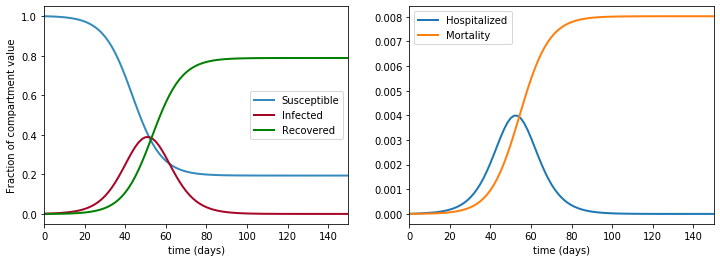

In [5]:
#unpack and rescale simulation output
t = data['t']; S_t = data['S_t']; I_t = data['I_t']; Ic_t = data['Ic_t'] 

plt.figure(figsize=(12, 4)); plt.subplot(121) 
plt.plot(t,np.sum(S_t,0), color="#348ABD", lw=2, label = 'Susceptible')           #all susceptible
plt.plot(t,np.sum(I_t,0), color="#A60628", lw=2, label = 'Infected')              #all Infected
plt.plot(t,np.sum(Ic_t[0,:,:],0), color='green', lw=2, label = 'Recovered')    #all Recovered
plt.xlabel('time (days)');       plt.xlim(0,Tf);  
plt.ylabel('Fraction of compartment value');   plt.legend()

plt.subplot(122) 
for i in (1 + np.arange(len(subclasses)-1)):
    plt.plot(t,np.sum(Ic_t[i,:,:],0), lw=2, label = subclasses[i])
plt.legend(); plt.xlabel('time (days)'); plt.xlabel('time (days)'); plt.xlim(0,Tf);   

## Repeat same simulation using Galerkin Discretization and default integrator (odeint)

This integrator supports adaptive timestepping but it is not recommended for time-dependent contact matrices or non-smooth dynamic more generally.

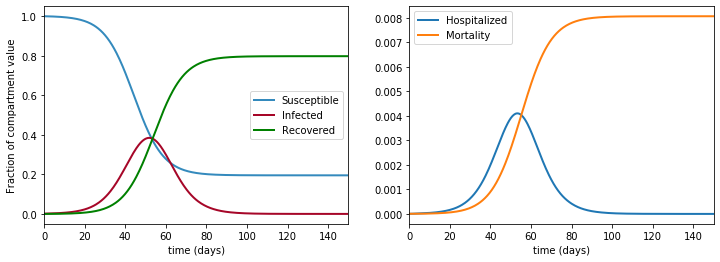

In [6]:
parameters['NL'] = 5
model = pyrosstsi.deterministic.Simulator(parameters,'Galerkin')
IC    = model.get_IC()
data  = model.simulate(IC)#,10**-3,10**-2)# <- error tolerance options

#unpack and rescale simulation output
t = data['t']; S_t = data['S_t']; I_t = data['I_t']; Ic_t = data['Ic_t'] 

plt.figure(figsize=(12, 4)); plt.subplot(121) 
plt.plot(t,np.sum(S_t,0), color="#348ABD", lw=2, label = 'Susceptible')           #all susceptible
plt.plot(t,np.sum(I_t,0), color="#A60628", lw=2, label = 'Infected')              #all Infected
plt.plot(t,np.sum(Ic_t[0,:,:],0), color='green', lw=2, label = 'Recovered')    #all Recovered
plt.xlabel('time (days)');       plt.xlim(0,Tf);  
plt.ylabel('Fraction of compartment value');   plt.legend()

plt.subplot(122) 
for i in (1 + np.arange(len(subclasses)-1)):
    plt.plot(t,np.sum(Ic_t[i,:,:],0), lw=2, label = subclasses[i])
plt.legend(); plt.xlabel('time (days)'); plt.xlabel('time (days)'); plt.xlim(0,Tf);  

## Repeat the same using Galerkin discretization and Crank Nicolson integrator

This integrator supports adaptive time-stepping and is preferable to 'odeint' whenever the contact matrix is time-dependent.  Still not recommended for non-smooth dynamics (e.g. lockdown).  When the contact matrix is time-dependent and piecewise smooth, consider using the Hybrid method (see example notebook on the subject).

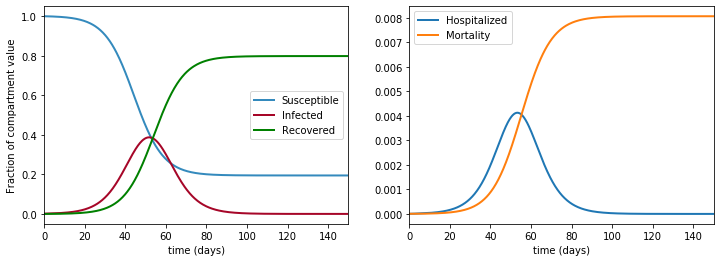

In [7]:
parameters['NL'] = 5
model = pyrosstsi.deterministic.Simulator(parameters,'Galerkin','Crank Nicolson')
IC    = model.get_IC()
data  = model.simulate(IC)#,10**-1,10**-1)# <- error tolerance options

#unpack and rescale simulation output
t = data['t']; S_t = data['S_t']; I_t = data['I_t']; Ic_t = data['Ic_t'] 

plt.figure(figsize=(12, 4)); plt.subplot(121) 
plt.plot(t,np.sum(S_t,0), color="#348ABD", lw=2, label = 'Susceptible')           #all susceptible
plt.plot(t,np.sum(I_t,0), color="#A60628", lw=2, label = 'Infected')              #all Infected
plt.plot(t,np.sum(Ic_t[0,:,:],0), color='green', lw=2, label = 'Recovered')    #all Recovered
plt.xlabel('time (days)');       plt.xlim(0,Tf);  
plt.ylabel('Fraction of compartment value');   plt.legend()

plt.subplot(122) 
for i in (1 + np.arange(len(subclasses)-1)):
    plt.plot(t,np.sum(Ic_t[i,:,:],0), lw=2, label = subclasses[i])
plt.legend(); plt.xlabel('time (days)'); plt.xlabel('time (days)'); plt.xlim(0,Tf);  